# USAD

## Environment

In [1]:
!rm -r sample_data

In [2]:
!git clone https://github.com/manigalati/usad

Cloning into 'usad'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (66/66), done.


In [3]:
%cd usad

/content/usad


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [5]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Tesla T4 (UUID: GPU-8c7d4b22-c8a2-1d4d-9981-7f39110d869c)


## EDA - Data Pre-Processing

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

input/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
input/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


### Normal period

In [ ]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 51)

In [ ]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [ ]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [ ]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.121378,0.000109,0.006449,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.188674,0.0,0.003962,0.0,0.0,0.0,0.0,0.0,0.067998,0.435224,0.275616,0.527549,0.000146,0.000565,0.0,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.121378,0.000109,0.006722,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.188674,0.0,0.004138,0.0,0.0,0.0,0.0,0.0,0.067998,0.435224,0.275616,0.527549,0.000146,0.000565,0.0,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [ ]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 51)

In [ ]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [ ]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [ ]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.935973,0.935586,0.9336,0.5,1.0,0.5,0.5,0.0,1.0,0.999677,0.02816,0.980350,0.929175,0.0,1.0,0.0,0.0,1.0,0.909544,0.036437,0.398564,0.02134,0.980663,0.939499,0.962702,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.935973,0.936183,0.9336,0.5,1.0,0.5,0.5,0.0,1.0,0.999677,0.02816,0.981743,0.929131,0.0,1.0,0.0,0.0,1.0,0.909544,0.036437,0.398564,0.02134,0.980663,0.952672,0.962702,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [ ]:
window_size=12

In [ ]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [ ]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [ ]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 * .5 * windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 * .5 * windows_normal.shape[0])):int(np.floor(.5 * windows_normal.shape[0]))]
windows_normal_test = windows_normal[int(np.floor(.5 * windows_normal.shape[0])):]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(np.concatenate([windows_normal_test,windows_attack])).float().view(([windows_normal_test.shape[0]+windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0647, val_loss2: 0.0686
Epoch [1], val_loss1: 0.0395, val_loss2: -0.0014
Epoch [2], val_loss1: 0.0331, val_loss2: -0.0130
Epoch [3], val_loss1: 0.0356, val_loss2: -0.0201
Epoch [4], val_loss1: 0.0362, val_loss2: -0.0236
Epoch [5], val_loss1: 0.0360, val_loss2: -0.0255
Epoch [6], val_loss1: 0.0347, val_loss2: -0.0263
Epoch [7], val_loss1: 0.0325, val_loss2: -0.0254
Epoch [8], val_loss1: 0.0332, val_loss2: -0.0270
Epoch [9], val_loss1: 0.0351, val_loss2: -0.0292
Epoch [10], val_loss1: 0.0339, val_loss2: -0.0287
Epoch [11], val_loss1: 0.0323, val_loss2: -0.0276
Epoch [12], val_loss1: 0.0182, val_loss2: -0.0156
Epoch [13], val_loss1: 0.0174, val_loss2: -0.0150
Epoch [14], val_loss1: 0.0164, val_loss2: -0.0144
Epoch [15], val_loss1: 0.0179, val_loss2: -0.0158
Epoch [16], val_loss1: 0.0183, val_loss2: -0.0164
Epoch [17], val_loss1: 0.0174, val_loss2: -0.0158
Epoch [18], val_loss1: 0.0131, val_loss2: -0.0118
Epoch [19], val_loss1: 0.0128, val_loss2: -0.0115
Epoch [20],

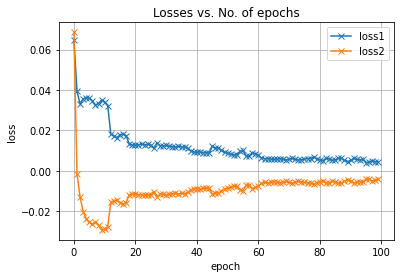

In [ ]:
plot_history(history)

In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [ ]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [ ]:
results=testing(model,test_loader)

In [ ]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])
y_test=np.concatenate([np.zeros(windows_normal_test.shape[0]),
                       np.ones(windows_attack.shape[0])])

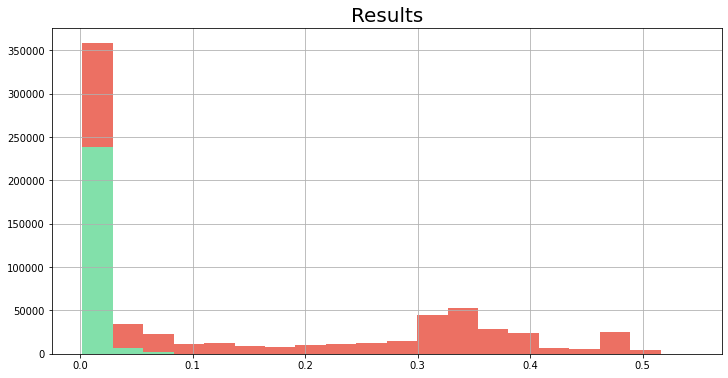

In [ ]:
histogram(y_test,y_pred)

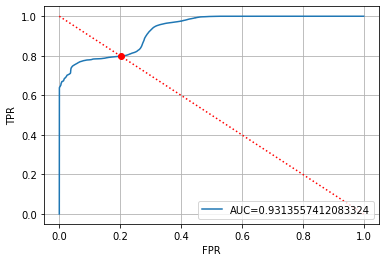

In [ ]:
threshold=ROC(y_test,y_pred)

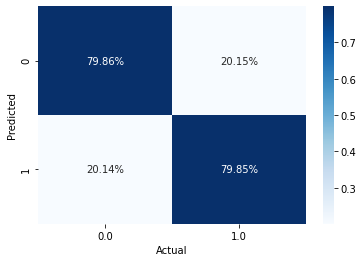

In [ ]:
confusion_matrix(y_test,np.where(y_pred > threshold, 1, 0),perc=True)